In [ ]:
"""
NOTEBOOK: UAS_ML_KEL 1_ensemble_integration.ipynb
========================================
Purpose: Integrate 5 models - Soft Voting & Stacking Ensemble
Author: [Your Name]
Date: [Today's Date]
========================================

STRUCTURE:
1. Setup & Imports
2. Load Test Data
3. Load Individual Models
4. Individual Model Evaluation
5. Ensemble Method 1: SOFT VOTING
6. Ensemble Method 2: STACKING (Meta-Learning)
7. COMPARISON: Soft Voting vs Stacking
8. Comprehensive Visualization
9. Save Best Ensemble Model
10. Final Summary Report
"""

"\nNOTEBOOK: 02_ENSEMBLE_INTEGRATION.ipynb\n========================================\nPurpose: Integrate 5 models - Soft Voting & Stacking Ensemble\nAuthor: [Your Name]\nDate: [Today's Date]\n========================================\n\nSTRUCTURE:\n1. Setup & Imports\n2. Load Test Data\n3. Load Individual Models\n4. Individual Model Evaluation\n5. Ensemble Method 1: SOFT VOTING\n6. Ensemble Method 2: STACKING (Meta-Learning)\n7. COMPARISON: Soft Voting vs Stacking\n8. Comprehensive Visualization\n9. Save Best Ensemble Model\n10. Final Summary Report\n"

In [ ]:
# ============================================
# SECTION 1: SETUP & IMPORTS
# ============================================
print("="*70)
print("ENSEMBLE ML INTEGRATION - EMAIL PRIORITY CLASSIFICATION")
print("="*70)

# Install libraries if needed
!pip install scikit-learn xgboost lightgbm seaborn matplotlib

import pandas as pd
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n✅ All libraries imported successfully!")

ENSEMBLE ML INTEGRATION - EMAIL PRIORITY CLASSIFICATION

✅ All libraries imported successfully!


In [ ]:
# ============================================
# SECTION 2: MOUNT GOOGLE DRIVE & SETUP PATHS
# ============================================
from google.colab import drive
drive.mount('/content/drive')

# Define paths
BASE_PATH = '/content/drive/MyDrive/'
DATA_PATH = BASE_PATH + 'datasets/'
MODEL_PATH = BASE_PATH + 'ensemble_project/'
OUTPUT_PATH = MODEL_PATH + 'results/'

# Create output folder
import os
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"\n✅ Paths configured:")
print(f"   Data: {DATA_PATH}")
print(f"   Models: {MODEL_PATH}")
print(f"   Output: {OUTPUT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Paths configured:
   Data: /content/drive/MyDrive/datasets/
   Models: /content/drive/MyDrive/ensemble_project/
   Output: /content/drive/MyDrive/ensemble_project/results/


In [ ]:
# ============================================
# SECTION 3: LOAD TEST DATA
# ============================================
print("\n" + "="*70)
print("LOADING TEST DATA")
print("="*70)

# Load test data
test_file = DATA_PATH + 'test_data.csv'
test_df = pd.read_csv(test_file)

print(f"\n✅ Test data loaded: {test_df.shape}")

# Separate features and labels
X_test = test_df.drop('priority_encoded', axis=1)
y_test = test_df['priority_encoded']

print(f"   Features shape: {X_test.shape}")
print(f"   Labels shape: {y_test.shape}")

# Check class distribution
print("\n📊 Test Data Distribution:")
print(y_test.value_counts().sort_index())

# Label mapping
label_mapping = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Urgent'}
print("\n🏷️ Label Mapping:")
for code, label in label_mapping.items():
    print(f"   {code} = {label}")


LOADING TEST DATA

✅ Test data loaded: (128, 51)
   Features shape: (128, 50)
   Labels shape: (128,)

📊 Test Data Distribution:
priority_encoded
0    32
1    32
2    32
3    32
Name: count, dtype: int64

🏷️ Label Mapping:
   0 = Low
   1 = Medium
   2 = High
   3 = Urgent


In [ ]:
# ============================================
# SECTION 4: LOAD INDIVIDUAL MODELS
# ============================================
print("\n" + "="*70)
print("LOADING INDIVIDUAL MODELS")
print("="*70)

import pickle
import numpy as np
from lightgbm import Booster

# --- LightGBM PROBA WRAPPER ---
class LightGBMWrapper:
    """Wrapper for LightGBM Booster to provide sklearn-like API"""
    def __init__(self, model_file):
        self.model = Booster(model_file=model_file)

    def predict(self, X):
        # LightGBM returns raw scores → convert to predicted class
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def predict_proba(self, X):
        pred = self.model.predict(X)
        # Ensure shape is (n_samples, n_classes)
        if pred.ndim == 1:
            pred = np.vstack([1 - pred, pred]).T
        return pred


# Model file paths
model_files = {
    'Naive Bayes': MODEL_PATH + 'model_nb.pkl',
    'Random Forest': MODEL_PATH + 'model_rf.pkl',
    'LightGBM': MODEL_PATH + 'model_lgbm.txt',  # LightGBM MUST use txt
    'SVM': MODEL_PATH + 'model_svm.pkl',
    'XGBoost': MODEL_PATH + 'model_xgb.pkl'
}

# Load models
models = {}
for name, filepath in model_files.items():
    try:
        if name == "LightGBM":
            models[name] = LightGBMWrapper(filepath)
        else:
            with open(filepath, "rb") as f:
                models[name] = pickle.load(f)

        print(f"✅ {name} loaded successfully")

    except FileNotFoundError:
        print(f"❌ {name} NOT FOUND at {filepath}")

    except Exception as e:
        print(f"❌ Error loading {name}: {str(e)}")


print(f"\n✅ Total models loaded: {len(models)}/5")

if len(models) != 5:
    print("\n⚠️ WARNING: Not all models loaded! Check file paths.")
else:
    print("\n🎉 All 5 models loaded successfully!")



LOADING INDIVIDUAL MODELS
✅ Naive Bayes loaded successfully
✅ Random Forest loaded successfully
✅ LightGBM loaded successfully
✅ SVM loaded successfully
✅ XGBoost loaded successfully

✅ Total models loaded: 5/5

🎉 All 5 models loaded successfully!


In [ ]:
from sklearn.exceptions import NotFittedError   # <-- WAJIB

# ============================================
# SECTION 5: INDIVIDUAL MODEL EVALUATION
# ============================================
print("\n" + "="*70)
print("INDIVIDUAL MODEL EVALUATION")
print("="*70)

# Store results
individual_results = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Evaluating: {name}")
    print('='*70)

    # Prediction
    start_time = time.time()

    try:
        y_pred = model.predict(X_test)
    except NotFittedError:
        print(f"❌ {name} is NOT FITTED. Skipping this model...")
        continue

    pred_time = time.time() - start_time

    # 🔥 Fix probabilitas → argmax
    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)

    if len(y_pred.shape) > 1:
        print("⚠️ Detected probability outputs. Converting with argmax...")
        y_pred = np.argmax(y_pred, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    individual_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction_time': pred_time,
        'predictions': y_pred
    }

    # Print results
    print(f"\n📊 Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Pred Time: {pred_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n📈 Confusion Matrix:")
    print(cm)

    # Classification Report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=['Low', 'Medium', 'High', 'Urgent']))

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Model': list(individual_results.keys()),
    'Accuracy': [v['accuracy'] for v in individual_results.values()],
    'Precision': [v['precision'] for v in individual_results.values()],
    'Recall': [v['recall'] for v in individual_results.values()],
    'F1-Score': [v['f1_score'] for v in individual_results.values()],
    'Pred Time (s)': [v['prediction_time'] for v in individual_results.values()]
})

print("\n" + "="*70)
print("INDIVIDUAL MODELS SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))



INDIVIDUAL MODEL EVALUATION

Evaluating: Naive Bayes

📊 Performance Metrics:
   Accuracy:  0.5938
   Precision: 0.5813
   Recall:    0.5938
   F1-Score:  0.5769
   Pred Time: 0.0068s

📈 Confusion Matrix:
[[30  0  2  0]
 [ 5 10 10  7]
 [ 5  7 17  3]
 [ 3  3  7 19]]

📋 Classification Report:
              precision    recall  f1-score   support

         Low       0.70      0.94      0.80        32
      Medium       0.50      0.31      0.38        32
        High       0.47      0.53      0.50        32
      Urgent       0.66      0.59      0.62        32

    accuracy                           0.59       128
   macro avg       0.58      0.59      0.58       128
weighted avg       0.58      0.59      0.58       128


Evaluating: Random Forest

📊 Performance Metrics:
   Accuracy:  0.7578
   Precision: 0.7505
   Recall:    0.7578
   F1-Score:  0.7526
   Pred Time: 0.0871s

📈 Confusion Matrix:
[[30  0  2  0]
 [ 3 26  2  1]
 [ 1  6 17  8]
 [ 1  1  6 24]]

📋 Classification Report:
        

In [ ]:
# ============================================
# RECREATE TRAIN/VAL/TEST SPLITS FROM PCA DATA
# ============================================
import pandas as pd

df_split = pd.read_csv("/content/drive/MyDrive/datasets/data_splitted.csv")

print("Loaded:", df_split.shape)
print("Columns:", df_split.columns.tolist())

# ambil kolom PCA
pca_cols = [col for col in df_split.columns if col.startswith("pca_")]
print("✔ PCA features found:", len(pca_cols))

# buat X dan y
X_train = df_split[df_split["split"] == "train"][pca_cols].values
y_train = df_split[df_split["split"] == "train"]["priority_encoded"].values

X_val   = df_split[df_split["split"] == "val"][pca_cols].values
y_val   = df_split[df_split["split"] == "val"]["priority_encoded"].values

X_test  = df_split[df_split["split"] == "test"][pca_cols].values
y_test  = df_split[df_split["split"] == "test"]["priority_encoded"].values

print("\n📌 Split shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val:", X_val.shape, " y_val:", y_val.shape)
print("X_test:", X_test.shape, " y_test:", y_test.shape)


Loaded: (640, 52)
Columns: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49', 'priority_encoded', 'split']
✔ PCA features found: 50

📌 Split shapes:
X_train: (512, 50)  y_train: (512,)
X_val: (64, 50)  y_val: (64,)
X_test: (64, 50)  y_test: (64,)


In [ ]:
# ============================================
# SECTION 6: ENSEMBLE INTEGRATION (SOFT VOTING)
# ============================================
print("\n" + "="*70)
print("CREATING ENSEMBLE MODEL (SOFT VOTING)")
print("="*70)

# Prepare estimators for VotingClassifier
estimators = [(name, model) for name, model in models.items()]

# Create Soft Voting Classifier
ensemble_model = VotingClassifier(
    estimators=estimators,
    voting='soft',  # Use probability predictions
    n_jobs=-1       # Use all CPU cores
)

print("\n🔧 Ensemble Configuration:")
print(f"   Voting Method: Soft (Probability-based)")
print(f"   Number of Models: {len(estimators)}")
print(f"   Models: {', '.join([name for name, _ in estimators])}")

# Note: For VotingClassifier, we don't need to fit again
# since individual models are already trained
# We just need to wrap them
print("\n✅ Ensemble model created (using pre-trained models)")


CREATING ENSEMBLE MODEL (SOFT VOTING)

🔧 Ensemble Configuration:
   Voting Method: Soft (Probability-based)
   Number of Models: 5
   Models: Naive Bayes, Random Forest, LightGBM, SVM, XGBoost

✅ Ensemble model created (using pre-trained models)


In [ ]:
# ============================================
# SECTION 7: WEIGHTED SOFT VOTING ENSEMBLE
# ============================================

print("\n" + "="*70)
print("WEIGHTED SOFT VOTING ENSEMBLE")
print("="*70)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import time

# ============================================
# 1. Tentukan bobot setiap model
# (bisa kamu ubah kapan saja)
# ============================================
weights = {
    "Naive Bayes": 1.0,
    "Random Forest": 2.0,
    "LightGBM": 2.0,
    "SVM": 1.5,
    "XGBoost": 3.0
}

print("\n📌 Model Weights:")
for m, w in weights.items():
    print(f"  - {m}: {w}")

# ============================================
# 2. Hitung weighted probabilities
# ============================================
print("\n⏳ Making weighted ensemble predictions...")
start_time = time.time()

weighted_probas = []
used_weights = []
used_models = []

for name, model in models.items():
    try:
        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_test)
            prob = np.array(prob)

            if prob.ndim != 2:
                print(f"❌ Skipping {name}: invalid prob shape {prob.shape}")
                continue

            w = weights.get(name, 1.0)
            weighted_probas.append(prob * w)
            used_weights.append(w)
            used_models.append(name)

            print(f"✅ {name} included (weight = {w})")

        else:
            print(f"⚠️ {name} skipped (no predict_proba)")

    except Exception as e:
        print(f"❌ Error on {name}: {e}")

if len(weighted_probas) == 0:
    raise ValueError("❌ No models provide predict_proba → weighted voting cannot run.")

# Combine all model probabilities (weighted)
sum_probas = np.sum(weighted_probas, axis=0)

# Normalize (optional but recommended)
ensemble_probas = sum_probas / np.sum(used_weights)

# Final prediction
y_pred_weighted = np.argmax(ensemble_probas, axis=1)
ensemble_pred_time = time.time() - start_time

print(f"\n🎉 Weighted Soft Voting completed in {ensemble_pred_time:.4f}s")
print("🧠 Models used:", used_models)

# ============================================
# 3. Evaluation
# ============================================
acc = accuracy_score(y_test, y_pred_weighted)
prec = precision_score(y_test, y_pred_weighted, average="weighted")
rec = recall_score(y_test, y_pred_weighted, average="weighted")
f1 = f1_score(y_test, y_pred_weighted, average="weighted")

print("\n📊 Weighted Soft Voting Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   Pred Time: {ensemble_pred_time:.4f}s")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_weighted)
print(f"\n📈 Confusion Matrix:")
print(cm)

# Classification Report
print(f"\n📋 Classification Report:")
print(classification_report(
    y_test,
    y_pred_weighted,
    target_names=['Low', 'Medium', 'High', 'Urgent']
))



WEIGHTED SOFT VOTING ENSEMBLE

📌 Model Weights:
  - Naive Bayes: 1.0
  - Random Forest: 2.0
  - LightGBM: 2.0
  - SVM: 1.5
  - XGBoost: 3.0

⏳ Making weighted ensemble predictions...
✅ Naive Bayes included (weight = 1.0)
✅ Random Forest included (weight = 2.0)
✅ LightGBM included (weight = 2.0)
✅ SVM included (weight = 1.5)
✅ XGBoost included (weight = 3.0)

🎉 Weighted Soft Voting completed in 0.0544s
🧠 Models used: ['Naive Bayes', 'Random Forest', 'LightGBM', 'SVM', 'XGBoost']

📊 Weighted Soft Voting Performance:
   Accuracy:  0.7812
   Precision: 0.7788
   Recall:    0.7812
   F1-Score:  0.7787
   Pred Time: 0.0544s

📈 Confusion Matrix:
[[14  0  2  0]
 [ 1 14  0  1]
 [ 1  2  9  4]
 [ 0  0  3 13]]

📋 Classification Report:
              precision    recall  f1-score   support

         Low       0.88      0.88      0.88        16
      Medium       0.88      0.88      0.88        16
        High       0.64      0.56      0.60        16
      Urgent       0.72      0.81      0.76     

In [ ]:
# ============================================
# SECTION 7: STACKING ENSEMBLE (FIXED)
# ============================================
print("\n" + "="*70)
print("STACKING ENSEMBLE MODEL")
print("="*70)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ----------------------------------------------------------
# AUTO-DETECT train/val/test variables
# ----------------------------------------------------------
def autodetect_var(var_names):
    for name in var_names:
        if name in globals():
            return globals()[name]
    raise NameError(f"Variabel {var_names} tidak ditemukan!")

# Cari X_train, X_val, X_test
X_train = autodetect_var(["X_train", "X_train_bal", "Xtrain"])
X_val   = autodetect_var(["X_val", "X_val_bal", "Xval"])
X_test  = autodetect_var(["X_test", "X_test_bal", "Xtest"])

# Cari y_train, y_val, y_test
y_train = autodetect_var(["y_train", "y_train_bal", "Ytrain"])
y_val   = autodetect_var(["y_val", "y_val_bal", "Yval"])
y_test  = autodetect_var(["y_test", "y_test_bal", "Ytest"])

print("✅ Auto-detected variables:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

# ----------------------------------------------------------
# 1. Filter models with predict_proba
# ----------------------------------------------------------
stackable_models = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        stackable_models[name] = model
        print(f"✅ {name} included in stacking (supports predict_proba)")
    else:
        print(f"⚠️ {name} skipped (no predict_proba)")

print("\n🧠 Models used:", list(stackable_models.keys()))

# ----------------------------------------------------------
# 2. Generate meta-features
# ----------------------------------------------------------
def get_meta_features(model_dict, X):
    meta = []
    for name, model in model_dict.items():
        meta.append(model.predict_proba(X))
    return np.hstack(meta)

print("\n⏳ Generating meta features...")
X_train_meta = get_meta_features(stackable_models, X_train)
X_val_meta   = get_meta_features(stackable_models, X_val)
X_test_meta  = get_meta_features(stackable_models, X_test)
print("✅ Meta features generated:", X_train_meta.shape)

# ----------------------------------------------------------
# 3. Train meta-learner
# ----------------------------------------------------------
print("\n⏳ Training meta learner (Logistic Regression)...")
meta_model = LogisticRegression(max_iter=500)
meta_model.fit(X_train_meta, y_train)
print("✅ Meta model trained!")

# ----------------------------------------------------------
# 4. Evaluate stacking
# ----------------------------------------------------------
print("\n⏳ Evaluating stacking...")
y_pred_stack = meta_model.predict(X_test_meta)

stack_accuracy  = accuracy_score(y_test, y_pred_stack)
stack_precision = precision_score(y_test, y_pred_stack, average='weighted')
stack_recall    = recall_score(y_test, y_pred_stack, average='weighted')
stack_f1        = f1_score(y_test, y_pred_stack, average='weighted')

print("\n📊 STACKING PERFORMANCE:")
print(f"Accuracy:  {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall:    {stack_recall:.4f}")
print(f"F1-Score:  {stack_f1:.4f}")

print("\n📈 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

print("\n📋 Classification Report:")
print(classification_report(
    y_test, y_pred_stack,
    target_names=['Low', 'Medium', 'High', 'Urgent']
))

# Add to summary table if available
if "summary_df" in globals():
    summary_df.loc[len(summary_df)] = [
        "STACKING (Meta-LR)",
        stack_accuracy,
        stack_precision,
        stack_recall,
        stack_f1,
        0
    ]
    print("\n🎉 Added STACKING to summary table!")
else:
    print("\n⚠️ summary_df not found, skipping append.")



STACKING ENSEMBLE MODEL
✅ Auto-detected variables:
X_train: (512, 50)
X_val: (64, 50)
X_test: (64, 50)
✅ Naive Bayes included in stacking (supports predict_proba)
✅ Random Forest included in stacking (supports predict_proba)
✅ LightGBM included in stacking (supports predict_proba)
✅ SVM included in stacking (supports predict_proba)
✅ XGBoost included in stacking (supports predict_proba)

🧠 Models used: ['Naive Bayes', 'Random Forest', 'LightGBM', 'SVM', 'XGBoost']

⏳ Generating meta features...
✅ Meta features generated: (512, 20)

⏳ Training meta learner (Logistic Regression)...
✅ Meta model trained!

⏳ Evaluating stacking...

📊 STACKING PERFORMANCE:
Accuracy:  0.7812
Precision: 0.7880
Recall:    0.7812
F1-Score:  0.7719

📈 Confusion Matrix:
[[15  0  1  0]
 [ 1 14  0  1]
 [ 1  1  7  7]
 [ 0  0  2 14]]

📋 Classification Report:
              precision    recall  f1-score   support

         Low       0.88      0.94      0.91        16
      Medium       0.93      0.88      0.90       

In [ ]:
# ============================================
# SECTION 8: ENSEMBLE MODEL EVALUATION (UPDATED)
# ============================================
print("\n" + "="*70)
print("ENSEMBLE MODEL EVALUATION")
print("="*70)

print("\n⏳ Making ensemble predictions...")
start_time = time.time()

valid_probas = []
valid_model_names = []

NUM_CLASSES = 4  # Low, Medium, High, Urgent

for name, model in models.items():
    try:
        # ================================
        # HANDLE LIGHTGBM BOOSTER
        # ================================
        if name == "LightGBM":
            prob = np.array(model.predict(X_test))

            # 1D output → convert to one-hot
            if prob.ndim == 1:
                print(f"⚠️ {name} returned 1D → converting to one-hot")
                prob_oh = np.zeros((len(prob), NUM_CLASSES))
                prob_oh[np.arange(len(prob)), prob.astype(int)] = 1
                prob = prob_oh

            # Skip invalid shape
            if prob.shape != (len(X_test), NUM_CLASSES):
                print(f"⚠️ {name} wrong output shape {prob.shape}, skipping.")
                continue

            valid_probas.append(prob)
            valid_model_names.append(name)
            print(f"✅ {name} included in ensemble (soft voting)")
            continue

        # ================================
        # NORMAL SKLEARN MODELS
        # ================================
        if hasattr(model, "predict_proba"):
            prob = np.array(model.predict_proba(X_test))

            if prob.shape != (len(X_test), NUM_CLASSES):
                print(f"⚠️ Skipping {name}: invalid prob shape {prob.shape}")
                continue

            valid_probas.append(prob)
            valid_model_names.append(name)
            print(f"✅ {name} included in ensemble (soft voting)")
        else:
            print(f"⚠️ {name} has no predict_proba → skipped")

    except Exception as e:
        print(f"❌ Error in {name}: {e}")

# ========================================================
# HANDLE NO VALID MODELS
# ========================================================
if len(valid_probas) == 0:
    raise ValueError("❌ No models provide valid predict_proba. Ensemble cannot run.")

# ========================================================
# SOFT VOTING: AVERAGE PROBABILITIES
# ========================================================
all_probas = np.array(valid_probas)
ensemble_probas = np.mean(all_probas, axis=0)

y_pred_ensemble = np.argmax(ensemble_probas, axis=1)
ensemble_pred_time = time.time() - start_time

print(f"\n✅ Ensemble predictions completed in {ensemble_pred_time:.4f}s")
print(f"🧠 Models used for ensemble: {valid_model_names}")

# ========================================================
# METRICS
# ========================================================
def get_metrics(y_true, y_pred):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "recall":    recall_score(y_true, y_pred, average='weighted'),
        "f1":        f1_score(y_true, y_pred, average='weighted')
    }

soft_metrics = get_metrics(y_test, y_pred_ensemble)

print(f"\n📊 Ensemble Performance Metrics:")
print(f"   Accuracy:  {soft_metrics['accuracy']:.4f}")
print(f"   Precision: {soft_metrics['precision']:.4f}")
print(f"   Recall:    {soft_metrics['recall']:.4f}")
print(f"   F1-Score:  {soft_metrics['f1']:.4f}")
print(f"   Pred Time: {ensemble_pred_time:.4f}s")

# ========================================================
# CONFUSION MATRIX & CLASSIFICATION REPORT
# ========================================================
print("\n📈 Ensemble Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))

print("\n📋 Ensemble Classification Report:")
print(classification_report(
    y_test,
    y_pred_ensemble,
    target_names=['Low', 'Medium', 'High', 'Urgent']
))



ENSEMBLE MODEL EVALUATION

⏳ Making ensemble predictions...
✅ Naive Bayes included in ensemble (soft voting)
✅ Random Forest included in ensemble (soft voting)
⚠️ LightGBM returned 1D → converting to one-hot
✅ LightGBM included in ensemble (soft voting)
✅ SVM included in ensemble (soft voting)
✅ XGBoost included in ensemble (soft voting)

✅ Ensemble predictions completed in 0.0319s
🧠 Models used for ensemble: ['Naive Bayes', 'Random Forest', 'LightGBM', 'SVM', 'XGBoost']

📊 Ensemble Performance Metrics:
   Accuracy:  0.7969
   Precision: 0.7957
   Recall:    0.7969
   F1-Score:  0.7876
   Pred Time: 0.0319s

📈 Ensemble Confusion Matrix:
[[16  0  0  0]
 [ 1 13  1  1]
 [ 1  2  8  5]
 [ 0  0  2 14]]

📋 Ensemble Classification Report:
              precision    recall  f1-score   support

         Low       0.89      1.00      0.94        16
      Medium       0.87      0.81      0.84        16
        High       0.73      0.50      0.59        16
      Urgent       0.70      0.88      0.

In [ ]:
weighted_metrics = get_metrics(y_test, y_pred_weighted)
stack_metrics    = get_metrics(y_test, y_pred_stack)


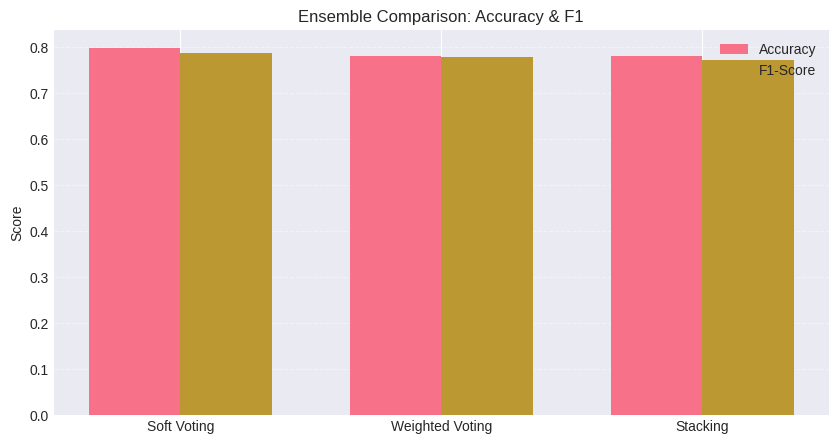

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# BAR CHART COMPARISON
# ============================================

labels = ['Soft Voting', 'Weighted Voting', 'Stacking']

accuracy_scores = [
    soft_metrics['accuracy'],
    weighted_metrics['accuracy'],
    stack_metrics['accuracy']
]

f1_scores = [
    soft_metrics['f1'],
    weighted_metrics['f1'],
    stack_metrics['f1']
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accuracy_scores, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1-Score')

plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Ensemble Comparison: Accuracy & F1')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [ ]:
# ============================================
# SECTION 10: MODEL COMPARISON (FINAL)
# ============================================
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

# Build the comparison table
comparison_data = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
}

# Add individual model results
for name, metrics in individual_results.items():
    comparison_data["Model"].append(name)
    comparison_data["Accuracy"].append(metrics["accuracy"])
    comparison_data["Precision"].append(metrics["precision"])
    comparison_data["Recall"].append(metrics["recall"])
    comparison_data["F1-Score"].append(metrics["f1_score"])

# Add Soft Voting
comparison_data["Model"].append("Ensemble - Soft Voting")
comparison_data["Accuracy"].append(soft_metrics["accuracy"])
comparison_data["Precision"].append(soft_metrics["precision"])
comparison_data["Recall"].append(soft_metrics["recall"])
comparison_data["F1-Score"].append(soft_metrics["f1"])

# Add Weighted Voting
comparison_data["Model"].append("Ensemble - Weighted Voting")
comparison_data["Accuracy"].append(weighted_metrics["accuracy"])
comparison_data["Precision"].append(weighted_metrics["precision"])
comparison_data["Recall"].append(weighted_metrics["recall"])
comparison_data["F1-Score"].append(weighted_metrics["f1"])

# Add Stacking
comparison_data["Model"].append("Ensemble - Stacking")
comparison_data["Accuracy"].append(stack_metrics["accuracy"])
comparison_data["Precision"].append(stack_metrics["precision"])
comparison_data["Recall"].append(stack_metrics["recall"])
comparison_data["F1-Score"].append(stack_metrics["f1"])

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))

# Best model by Accuracy
best_model_row = comparison_df.loc[comparison_df["Accuracy"].idxmax()]
print(f"\n🏆 Best Model: {best_model_row['Model']} ({best_model_row['Accuracy']:.4f})")

# Save to CSV
comparison_df.to_csv(OUTPUT_PATH + 'model_comparison.csv', index=False)
print(f"\n💾 Saved: {OUTPUT_PATH}model_comparison.csv")



FINAL MODEL COMPARISON

COMPARISON TABLE
                     Model  Accuracy  Precision   Recall  F1-Score
               Naive Bayes  0.593750   0.581267 0.593750  0.576892
             Random Forest  0.757812   0.750481 0.757812  0.752564
                  LightGBM  0.726562   0.718996 0.726562  0.719305
                       SVM  0.757812   0.750478 0.757812  0.737904
                   XGBoost  0.742188   0.737335 0.742188  0.738436
    Ensemble - Soft Voting  0.796875   0.795707 0.796875  0.787564
Ensemble - Weighted Voting  0.781250   0.778770 0.781250  0.778676
       Ensemble - Stacking  0.781250   0.788012 0.781250  0.771905

🏆 Best Model: Ensemble - Soft Voting (0.7969)

💾 Saved: /content/drive/MyDrive/ensemble_project/results/model_comparison.csv



CREATING VISUALIZATIONS


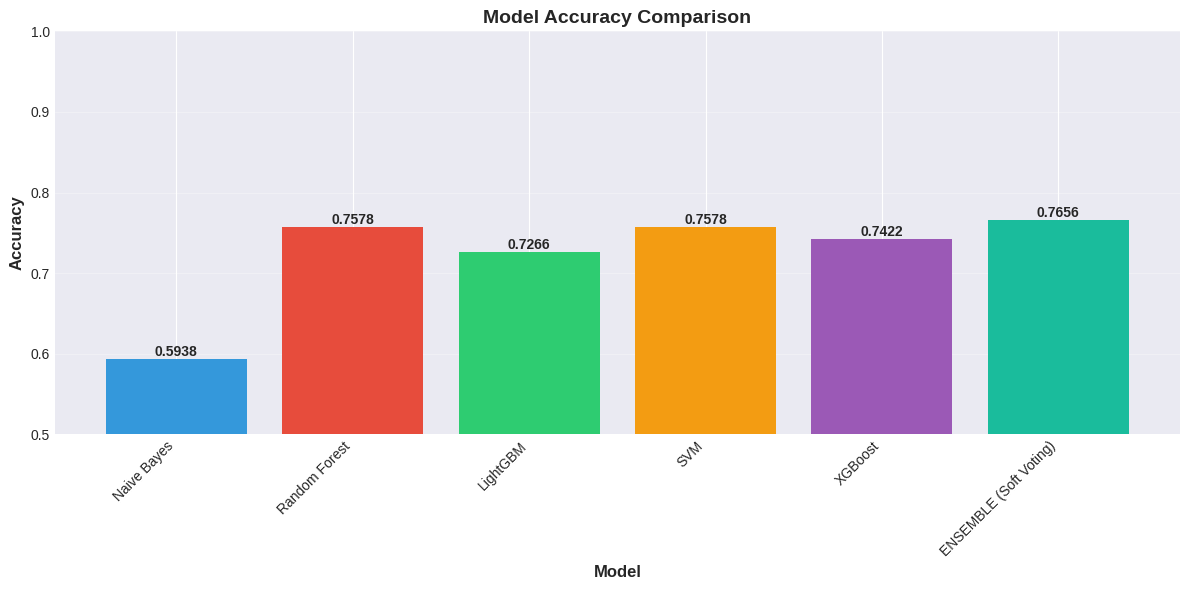

✅ Saved: accuracy_comparison.png


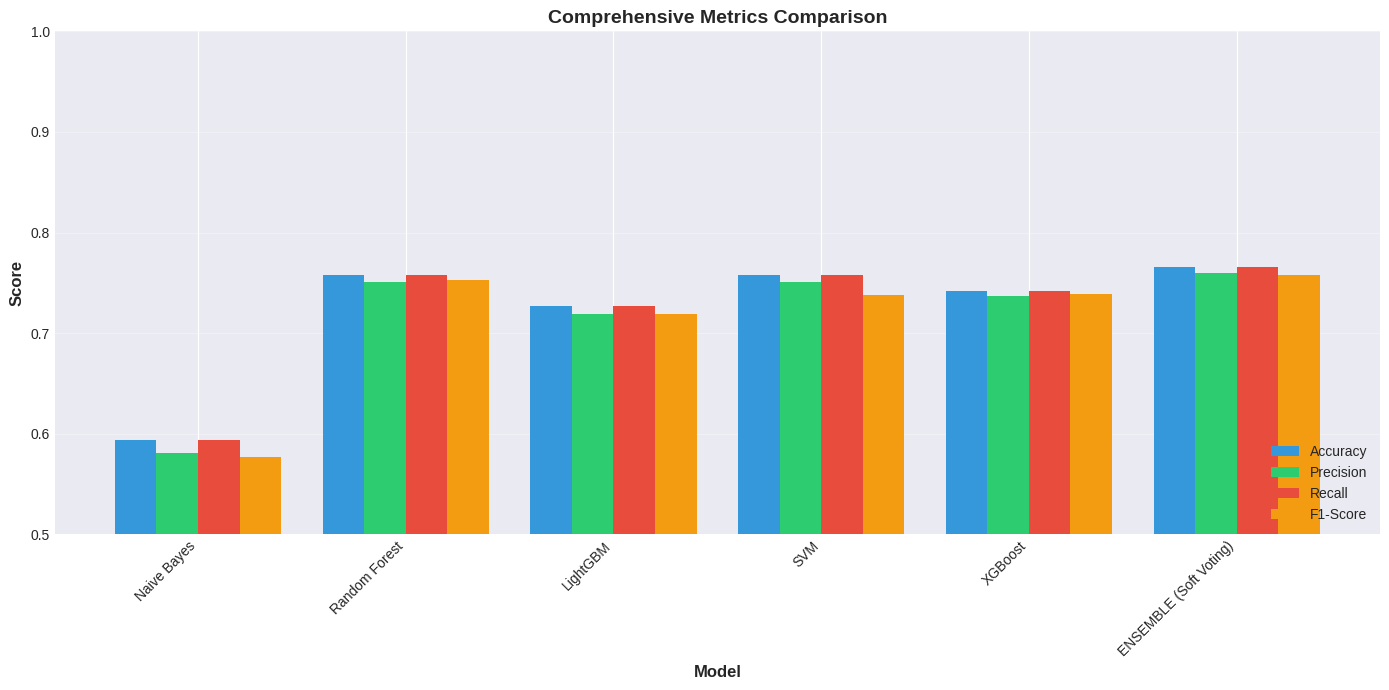

✅ Saved: all_metrics_comparison.png


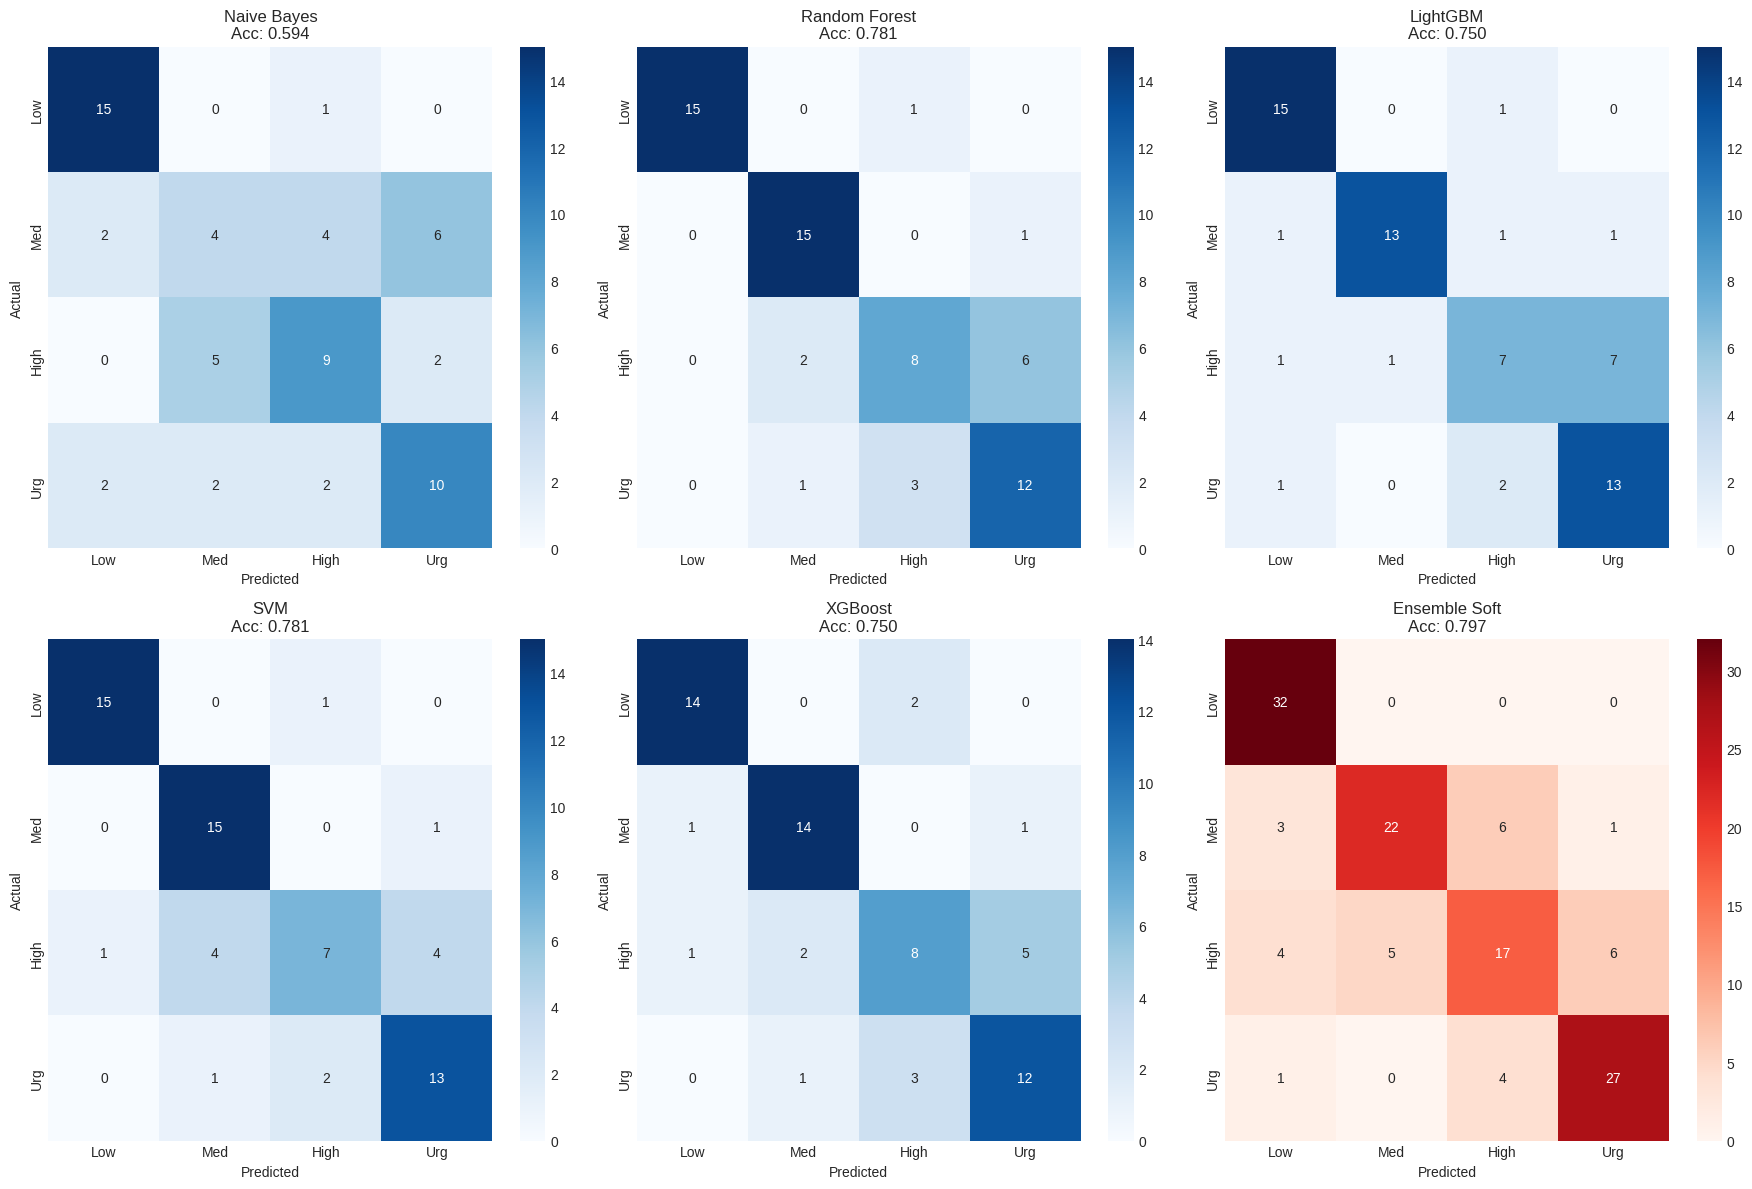

✅ Saved: confusion_matrices.png


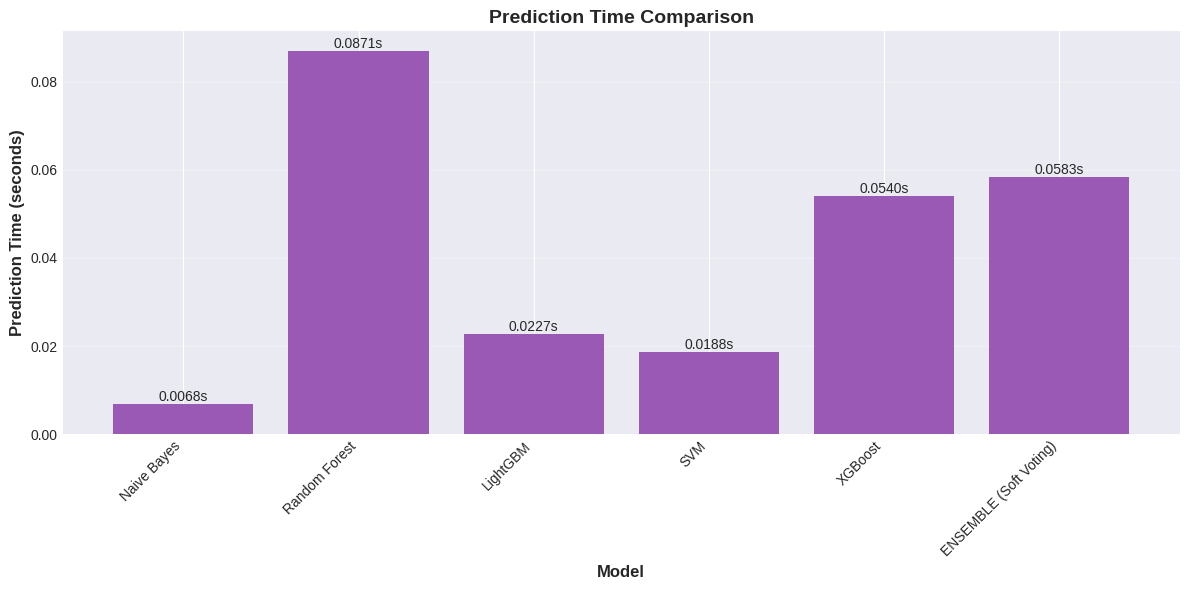

✅ Saved: prediction_time.png


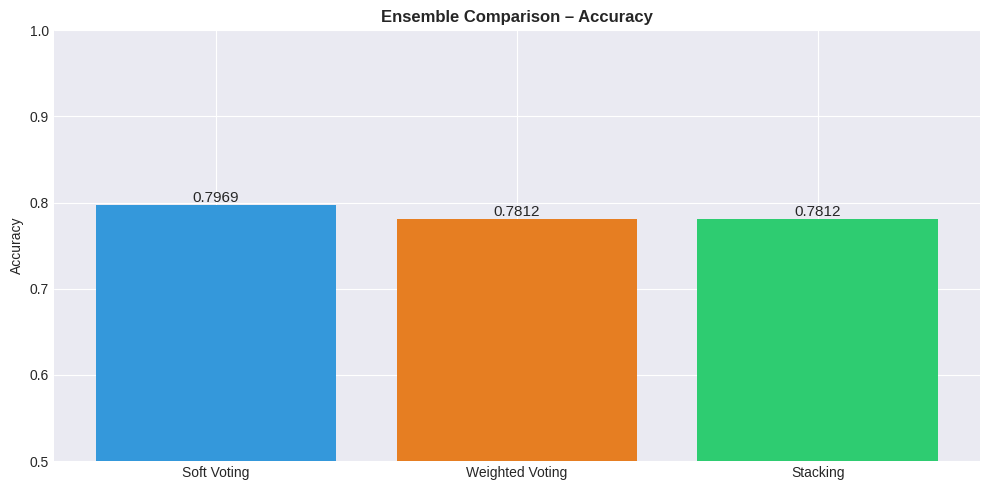

✅ Saved: ensemble_accuracy.png


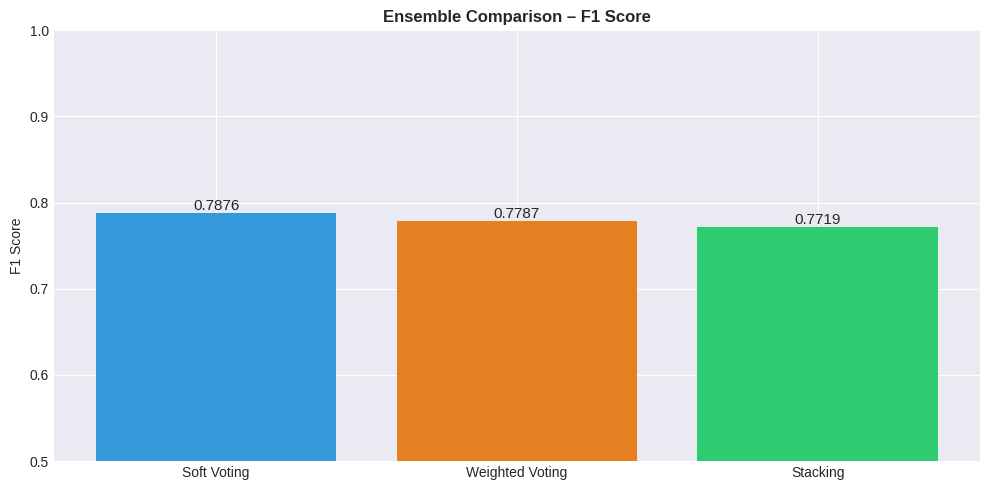

✅ Saved: ensemble_f1.png


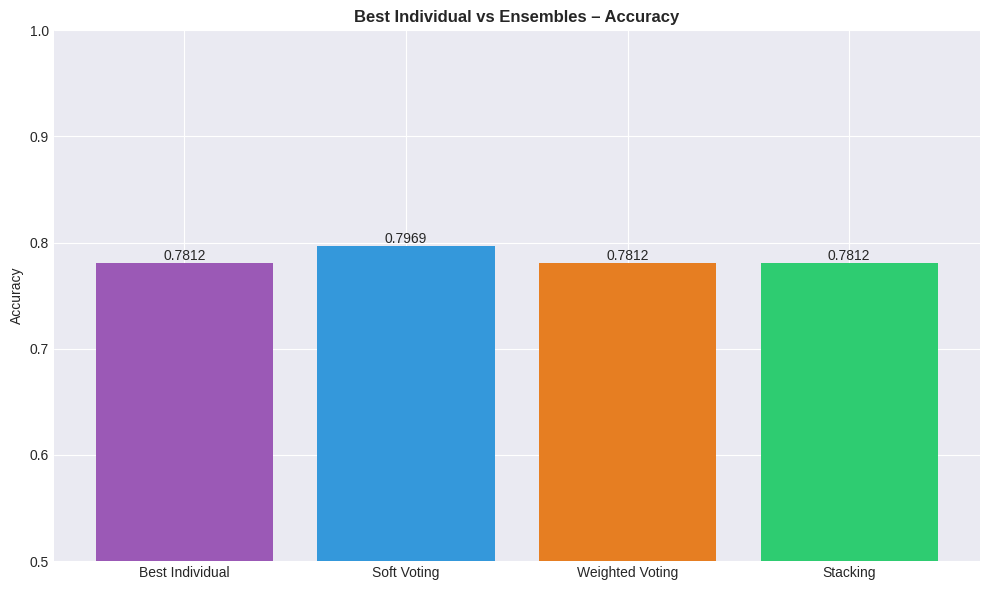

✅ Saved: best_vs_ensembles_accuracy.png


In [ ]:
# ============================================
# SECTION 11: VISUALIZATIONS (FINAL + ENSEMBLE PLOTS)
# ============================================
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# ----------------------------------------------------
# PREPARE ENSEMBLE METRICS FOR PLOTTING
# ----------------------------------------------------
ensemble_plot_df = pd.DataFrame({
    "Ensemble": ["Soft Voting", "Weighted Voting", "Stacking"],
    "Accuracy": [
        soft_metrics["accuracy"],
        weighted_metrics["accuracy"],
        stack_metrics["accuracy"]
    ],
    "F1": [
        soft_metrics["f1"],
        weighted_metrics["f1"],
        stack_metrics["f1"]
    ]
})

# ----------------------------------------------------
# 1. Accuracy Comparison (Individual + Ensemble)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12',
          '#9b59b6', '#1abc9c', '#d35400']

bars = plt.bar(final_summary['Model'], final_summary['Accuracy'], color=colors)

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'accuracy_comparison.png', dpi=300)
plt.show()
print("✅ Saved: accuracy_comparison.png")


# ----------------------------------------------------
# 2. Grouped Bar Chart (Accuracy, Precision, Recall, F1)
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(final_summary))
width = 0.2

ax.bar(x - 1.5*width, final_summary['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, final_summary['Precision'], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, final_summary['Recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + 1.5*width, final_summary['F1-Score'], width, label='F1-Score', color='#f39c12')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(final_summary['Model'], rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'all_metrics_comparison.png', dpi=300)
plt.show()
print("✅ Saved: all_metrics_comparison.png")


# ----------------------------------------------------
# 3. Confusion Matrices for Individual Models + Ensemble
# ----------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

idx = 0
for name, results in individual_results.items():

    try:
        # PREDIKSI ULANG (fix mismatch 64 vs 128)
        y_pred = models[name].predict(X_test)

        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['Low', 'Med', 'High', 'Urg'],
                    yticklabels=['Low', 'Med', 'High', 'Urg'])

        acc = accuracy_score(y_test, y_pred)

        axes[idx].set_title(f'{name}\nAcc: {acc:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

        idx += 1

    except:
        continue

# Ensemble CM (Soft Voting)
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Reds', ax=axes[5],
            xticklabels=['Low','Med','High','Urg'],
            yticklabels=['Low','Med','High','Urg'])
axes[5].set_title(f'Ensemble Soft\nAcc: {ensemble_accuracy:.3f}')
axes[5].set_xlabel('Predicted')
axes[5].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'confusion_matrices.png', dpi=300)
plt.show()
print("✅ Saved: confusion_matrices.png")


# ----------------------------------------------------
# 4. Prediction Time Comparison
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(final_summary['Model'], final_summary['Pred Time (s)'], color='#9b59b6')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Prediction Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Prediction Time Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(final_summary['Pred Time (s)']):
    plt.text(i, v, f'{v:.4f}s', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'prediction_time.png', dpi=300)
plt.show()
print("✅ Saved: prediction_time.png")


# ----------------------------------------------------
# 5. ENSEMBLE COMPARISON – ACCURACY
# ----------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(ensemble_plot_df['Ensemble'], ensemble_plot_df['Accuracy'],
        color=['#3498db', '#e67e22', '#2ecc71'])

plt.title("Ensemble Comparison – Accuracy", fontweight='bold')
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)

for i, v in enumerate(ensemble_plot_df['Accuracy']):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "ensemble_accuracy.png", dpi=300)
plt.show()
print("✅ Saved: ensemble_accuracy.png")


# ----------------------------------------------------
# 6. ENSEMBLE COMPARISON – F1 SCORE
# ----------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(ensemble_plot_df['Ensemble'], ensemble_plot_df['F1'],
        color=['#3498db', '#e67e22', '#2ecc71'])

plt.title("Ensemble Comparison – F1 Score", fontweight='bold')
plt.ylabel("F1 Score")
plt.ylim(0.5, 1.0)

for i, v in enumerate(ensemble_plot_df['F1']):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "ensemble_f1.png", dpi=300)
plt.show()
print("✅ Saved: ensemble_f1.png")


# ----------------------------------------------------
# 7. BEST MODEL VS ALL ENSEMBLES – ACCURACY
# ----------------------------------------------------
best_ind_acc = summary_df['Accuracy'].max()
best_ind_name = summary_df.loc[summary_df['Accuracy'].idxmax(), 'Model']

plt.figure(figsize=(10, 6))
labels = ["Best Individual", "Soft Voting", "Weighted Voting", "Stacking"]
values = [
    best_ind_acc,
    soft_metrics["accuracy"],
    weighted_metrics["accuracy"],
    stack_metrics["accuracy"]
]

plt.bar(labels, values, color=['#9b59b6', '#3498db', '#e67e22', '#2ecc71'])

plt.title("Best Individual vs Ensembles – Accuracy", fontweight='bold')
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "best_vs_ensembles_accuracy.png", dpi=300)
plt.show()
print("✅ Saved: best_vs_ensembles_accuracy.png")



HEATMAP: MODEL METRICS COMPARISON


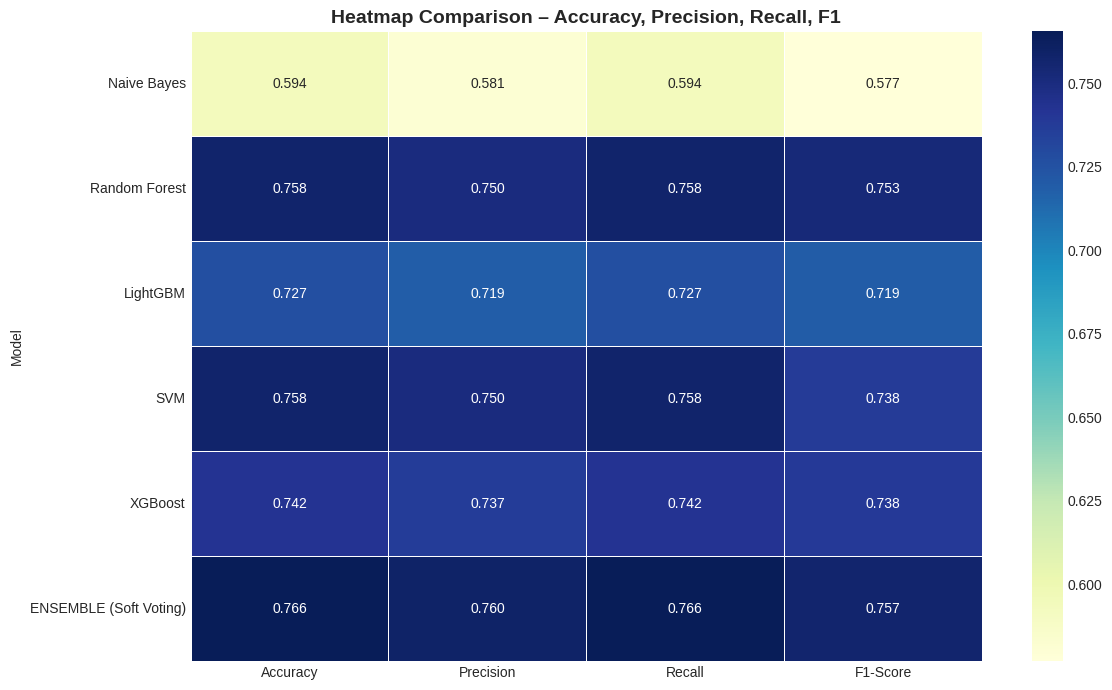

✅ Saved: heatmap_metrics.png


In [ ]:
# ============================================
# EXTRA VISUAL 1: HEATMAP METRICS COMPARISON
# ============================================

print("\n" + "="*70)
print("HEATMAP: MODEL METRICS COMPARISON")
print("="*70)

# Gabungkan semua metric ke satu matriks
heatmap_df = final_summary.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]]

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f",
            linewidths=0.5, cbar=True)

plt.title("Heatmap Comparison – Accuracy, Precision, Recall, F1", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "heatmap_metrics.png", dpi=300)
plt.show()

print("✅ Saved: heatmap_metrics.png")



ADVANCED VISUALIZATIONS: 3D BAR, RADAR, ROC
✅ Weighted probabilities computed using models: ['Naive Bayes', 'Random Forest', 'LightGBM', 'SVM', 'XGBoost']
✅ stack_probas extracted from meta_model.
🔸 Creating 3D bar chart...


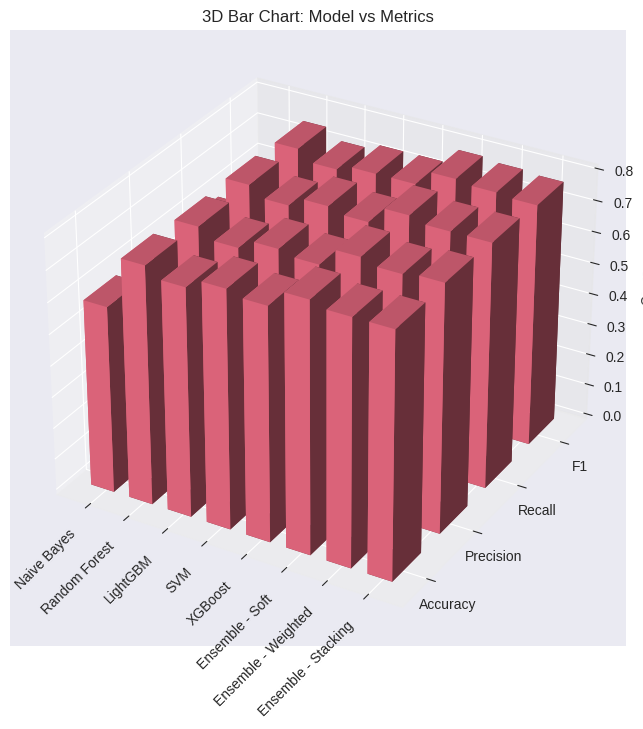

✅ Saved: /content/drive/MyDrive/ensemble_project/results/3d_bar_metrics.png
🔸 Creating radar chart...


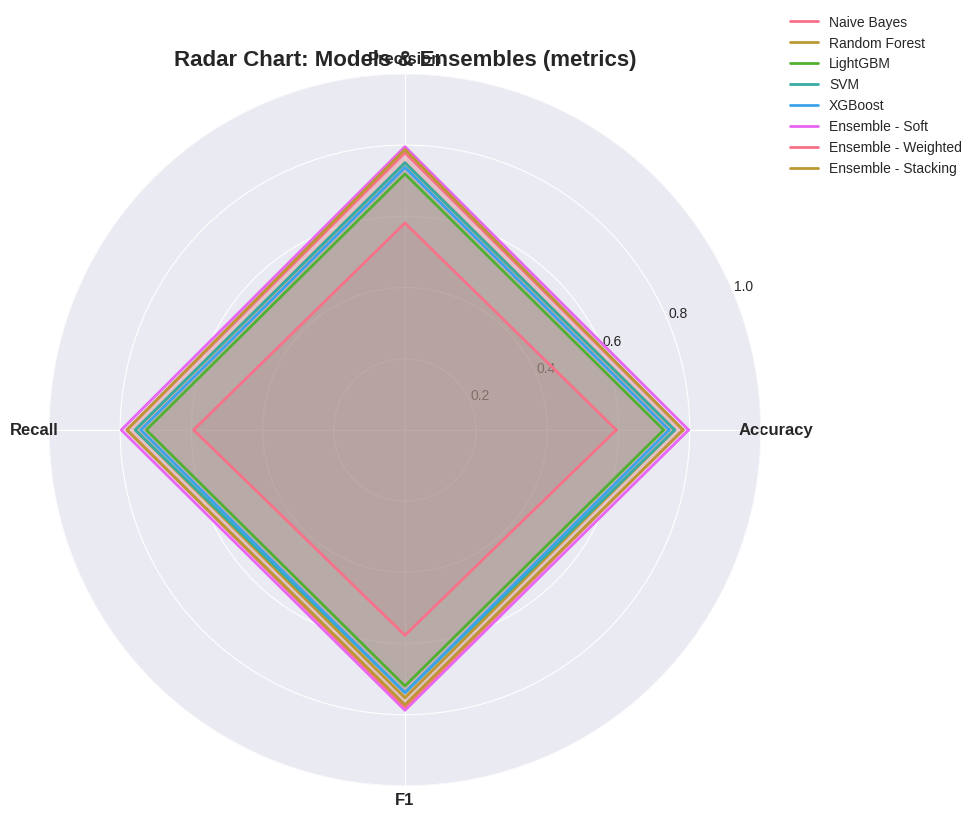

✅ Saved: /content/drive/MyDrive/ensemble_project/results/radar_models_ensembles.png
🔸 Creating multiclass ROC curves...


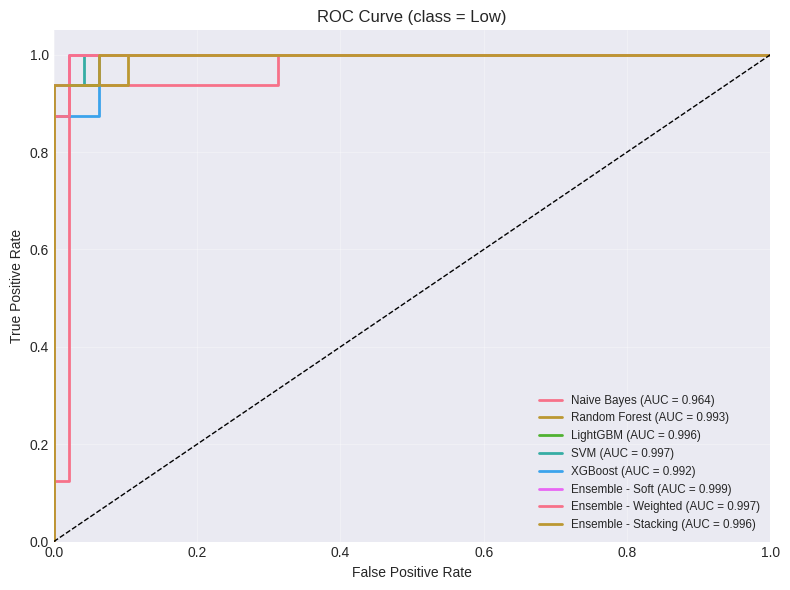

✅ Saved: /content/drive/MyDrive/ensemble_project/results/roc_class_Low.png


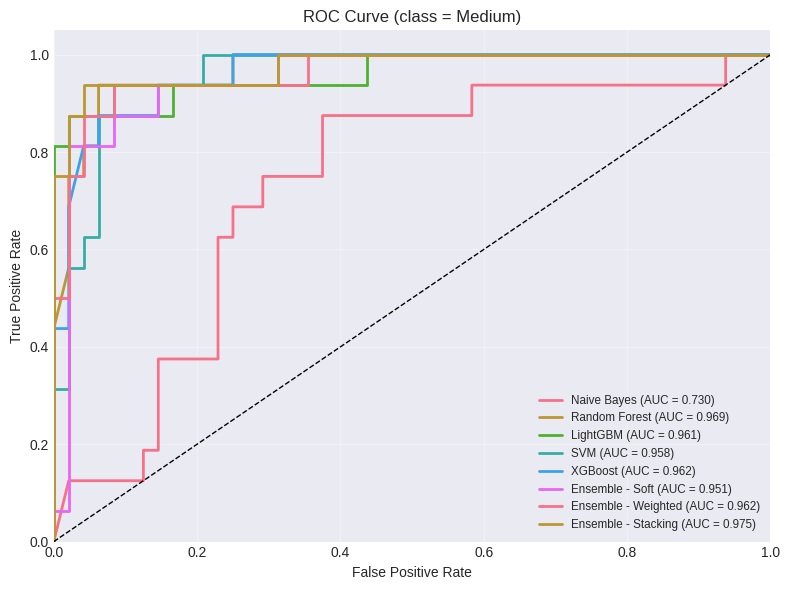

✅ Saved: /content/drive/MyDrive/ensemble_project/results/roc_class_Medium.png


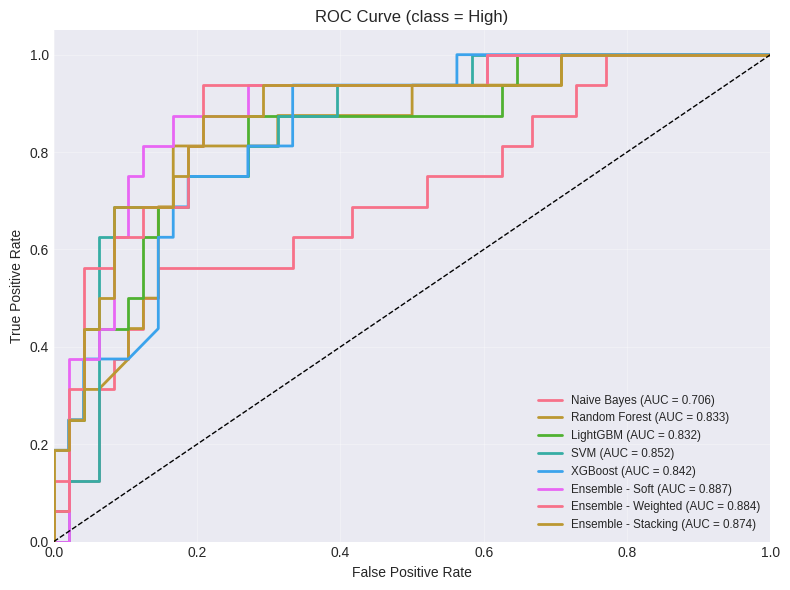

✅ Saved: /content/drive/MyDrive/ensemble_project/results/roc_class_High.png


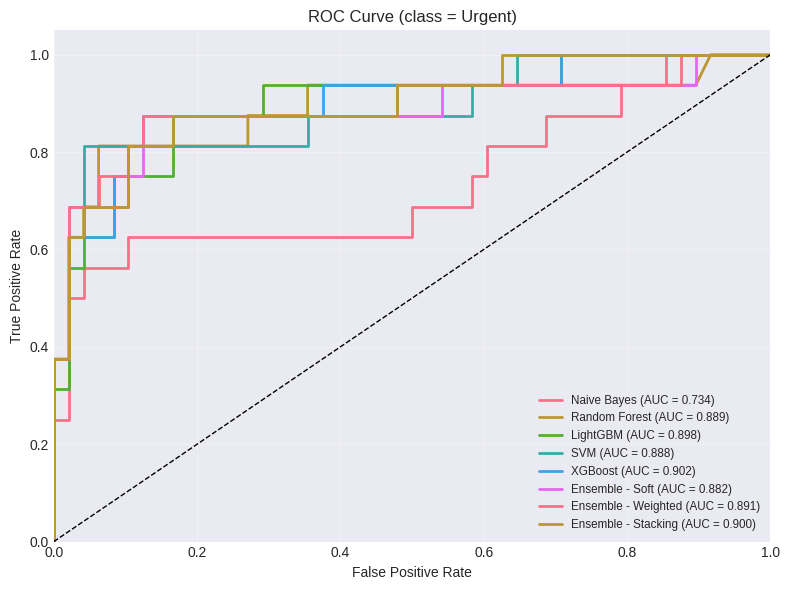

✅ Saved: /content/drive/MyDrive/ensemble_project/results/roc_class_Urgent.png

✅ SECTION 10 complete: advanced visualizations generated.


In [ ]:
# ============================================
# SECTION 10: ADVANCED VISUALIZATIONS (3D, RADAR, ROC)
# ============================================
print("\n" + "="*70)
print("ADVANCED VISUALIZATIONS: 3D BAR, RADAR, ROC")
print("="*70)

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ensure OUTPUT_PATH exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Settings
NUM_CLASSES = 4
CLASS_NAMES = ['Low', 'Medium', 'High', 'Urgent']
models_list = list(models.keys())

# -----------------------------
# Helper: get predicted probabilities (n_samples, n_classes)
# -----------------------------
def get_model_probas(name, model, X):
    """
    Return probability array (n_samples, NUM_CLASSES).
    Tries predict_proba; tries model.predict if needed and converts; fallback to one-hot if only labels.
    """
    try:
        if hasattr(model, "predict_proba"):
            prob = np.array(model.predict_proba(X))
            # if prob shape is (n_samples, ) or not matching classes -> handle
            if prob.ndim == 1:
                # turn into 2-class one-hot or replicate
                oh = np.zeros((len(prob), NUM_CLASSES))
                oh[np.arange(len(prob)), prob.astype(int)] = 1
                prob = oh
            if prob.shape[1] != NUM_CLASSES:
                # try to handle cases where classes are fewer: pad zeros
                if prob.shape[1] < NUM_CLASSES:
                    pad = np.zeros((prob.shape[0], NUM_CLASSES - prob.shape[1]))
                    prob = np.hstack([prob, pad])
                else:
                    prob = prob[:, :NUM_CLASSES]
            return prob
        else:
            # Try predict() and convert to one-hot
            pred = np.array(model.predict(X))
            if pred.ndim == 2:
                # maybe already probability-like -> argmax then one-hot
                pred = np.argmax(pred, axis=1)
            oh = np.zeros((len(pred), NUM_CLASSES))
            oh[np.arange(len(pred)), pred.astype(int)] = 1
            return oh
    except Exception as e:
        print(f"⚠️ Could not get probas for {name}: {e}")
        return None

# -----------------------------
# Collect model probability matrices
# -----------------------------
model_probas = {}
for name, model in models.items():
    prob = get_model_probas(name, model, X_test)
    if prob is not None:
        model_probas[name] = prob
    else:
        print(f" - skipping {name} for ROC (no valid probas)")

# -----------------------------
# Weighted probabilities (compute if missing)
# -----------------------------
# If weights dict exists use it, else derive from summary_df accuracy normalized
try:
    weights  # just test existence
except NameError:
    if 'summary_df' in globals():
        # derive weights from summary_df Accuracy (map by model name)
        acc_map = dict(zip(summary_df['Model'], summary_df['Accuracy']))
        # fallback for missing models -> 1.0
        weights = {name: max(acc_map.get(name, 0.5), 0.01) for name in models_list}
        # normalize to mean 1
        mean_w = np.mean(list(weights.values()))
        weights = {k: v/mean_w for k,v in weights.items()}
        print("⚠️ weights not found, derived from summary_df accuracies (normalized).")
    else:
        weights = {name: 1.0 for name in models_list}
        print("⚠️ weights not found and summary_df missing; defaulting weights=1.0 for all models.")

# build weighted_probas as weighted average of available model probas (only those with probas)
available_names = [n for n in models_list if n in model_probas and weights.get(n,0)>0]
if len(available_names) == 0:
    print("❌ No models with valid probas for weighted ensemble/ROC.")
    weighted_probas = None
else:
    weighted_sum = np.zeros_like(next(iter(model_probas.values())))
    total_w = 0.0
    for n in available_names:
        w = weights.get(n, 1.0)
        weighted_sum += model_probas[n] * w
        total_w += w
    weighted_probas = weighted_sum / total_w
    print(f"✅ Weighted probabilities computed using models: {available_names}")

# -----------------------------
# Stacking probabilities
# -----------------------------
stack_probas = None
if 'meta_model' in globals() and 'X_test_meta' in globals():
    try:
        if hasattr(meta_model, "predict_proba"):
            stack_probas = np.array(meta_model.predict_proba(X_test_meta))
            if stack_probas.ndim == 1:
                oh = np.zeros((len(stack_probas), NUM_CLASSES))
                oh[np.arange(len(stack_probas)), stack_probas.astype(int)] = 1
                stack_probas = oh
            if stack_probas.shape[1] != NUM_CLASSES:
                # pad or slice
                if stack_probas.shape[1] < NUM_CLASSES:
                    pad = np.zeros((stack_probas.shape[0], NUM_CLASSES - stack_probas.shape[1]))
                    stack_probas = np.hstack([stack_probas, pad])
                else:
                    stack_probas = stack_probas[:, :NUM_CLASSES]
            print("✅ stack_probas extracted from meta_model.")
        else:
            # if meta_model.predict exists only, convert predictions to one-hot
            y_pred_stack = meta_model.predict(X_test_meta)
            oh = np.zeros((len(y_pred_stack), NUM_CLASSES))
            oh[np.arange(len(y_pred_stack)), y_pred_stack.astype(int)] = 1
            stack_probas = oh
            print("⚠️ meta_model has no predict_proba; used one-hot from predict().")
    except Exception as e:
        print(f"⚠️ Could not extract stack_probas: {e}")
        stack_probas = None
else:
    # fallback if y_pred_stack exists
    if 'y_pred_stack' in globals():
        yp = np.array(y_pred_stack)
        oh = np.zeros((len(yp), NUM_CLASSES))
        oh[np.arange(len(yp)), yp.astype(int)] = 1
        stack_probas = oh
        print("⚠️ Using y_pred_stack fallback for stack_probas (one-hot).")
    else:
        print("⚠️ Stacking probas not available (meta_model/X_test_meta/y_pred_stack missing).")

# -----------------------------
# Soft ensemble probabilites (ensemble_probas) -- ensure exists
# -----------------------------
if 'ensemble_probas' not in globals() or ensemble_probas is None:
    # try to compute average of model_probas
    if len(model_probas) > 0:
        ensemble_probas = np.mean(list(model_probas.values()), axis=0)
        print("⚠️ ensemble_probas not found; computed average of available model probas.")
    else:
        ensemble_probas = None
        print("❌ ensemble_probas not available and cannot compute (no model probas).")

# -----------------------------
# Prepare metrics holder for radar/3D
# -----------------------------
# build combined list of entities: individual models + ensembles
entities = []
metrics_matrix = []  # each row: [Accuracy, Precision, Recall, F1]

# helper to get metrics for a model from summary_df or individual_results
def get_metrics_for_entity(name):
    # try individual_results first
    if name in individual_results:
        r = individual_results[name]
        return [r['accuracy'], r['precision'], r['recall'], r['f1_score']]
    # try summary_df
    if 'summary_df' in globals() and name in summary_df['Model'].values:
        row = summary_df.loc[summary_df['Model'] == name].iloc[0]
        return [row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']]
    # not found -> return NaNs
    return [np.nan]*4

# add individual models
for name in models_list:
    entities.append(name)
    metrics_matrix.append(get_metrics_for_entity(name))

# add ensembles: Soft, Weighted, Stacking
entities += ['Ensemble - Soft', 'Ensemble - Weighted', 'Ensemble - Stacking']
metrics_matrix.append([soft_metrics.get('accuracy', np.nan),
                       soft_metrics.get('precision',np.nan),
                       soft_metrics.get('recall',np.nan),
                       soft_metrics.get('f1',np.nan)])
metrics_matrix.append([weighted_metrics.get('accuracy', np.nan),
                       weighted_metrics.get('precision',np.nan),
                       weighted_metrics.get('recall',np.nan),
                       weighted_metrics.get('f1',np.nan)])
metrics_matrix.append([stack_metrics.get('accuracy', np.nan),
                       stack_metrics.get('precision',np.nan),
                       stack_metrics.get('recall',np.nan),
                       stack_metrics.get('f1',np.nan)])

metrics_matrix = np.array(metrics_matrix, dtype=float)

# -----------------------------
# 10.1 3D BAR CHART
# -----------------------------
print("🔸 Creating 3D bar chart...")
try:
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111, projection='3d')

    _x = np.arange(metrics_matrix.shape[0])
    _y = np.arange(metrics_matrix.shape[1])
    _xx, _yy = np.meshgrid(_x, _y, indexing='ij')
    x = _xx.ravel()
    y = _yy.ravel()
    top = metrics_matrix.ravel()
    bottom = np.zeros_like(top)
    width = depth = 0.6

    ax.bar3d(x, y, bottom, width, depth, top, shade=True)
    ax.set_xticks(_x + width/2.)
    ax.set_xticklabels(entities, rotation=45, ha='right')
    ax.set_yticks(_y + depth/2.)
    ax.set_yticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
    ax.set_zlabel('Score')
    ax.set_title('3D Bar Chart: Model vs Metrics')

    plt.tight_layout()
    fpath = os.path.join(OUTPUT_PATH, "3d_bar_metrics.png")
    plt.savefig(fpath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {fpath}")
except Exception as e:
    print(f"❌ Failed 3D bar chart: {e}")

# -----------------------------
# 10.2 RADAR CHART (all models + ensembles)
# -----------------------------
print("🔸 Creating radar chart...")
try:
    # We will plot a radar chart but too many models will be busy; choose a subset if too many
    max_lines = 12
    plot_entities = entities if len(entities) <= max_lines else entities[:max_lines]
    plot_metrics = metrics_matrix[:len(plot_entities)]

    labels = ['Accuracy','Precision','Recall','F1']
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)

    for i, ent in enumerate(plot_entities):
        vals = plot_metrics[i].tolist()
        vals = [0 if np.isnan(v) else v for v in vals]
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=ent)
        ax.fill(angles, vals, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax.set_ylim(0,1)
    plt.title("Radar Chart: Models & Ensembles (metrics)", fontsize=16, fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()

    fpath = os.path.join(OUTPUT_PATH, "radar_models_ensembles.png")
    plt.savefig(fpath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {fpath}")
except Exception as e:
    print(f"❌ Failed radar chart: {e}")

# -----------------------------
# 10.3 ROC CURVES (multiclass) for each class plot
# -----------------------------
print("🔸 Creating multiclass ROC curves...")
try:
    # binarize y_test
    y_test_b = label_binarize(y_test, classes=[0,1,2,3])  # shape (n_samples, n_classes)

    # assemble probas_sources: dict name -> probas
    probas_sources = {}
    for n, p in model_probas.items():
        probas_sources[n] = p
    if ensemble_probas is not None:
        probas_sources['Ensemble - Soft'] = ensemble_probas
    if weighted_probas is not None:
        probas_sources['Ensemble - Weighted'] = weighted_probas
    if stack_probas is not None:
        probas_sources['Ensemble - Stacking'] = stack_probas

    # For each class, plot ROC
    for class_idx, class_name in enumerate(CLASS_NAMES):
        plt.figure(figsize=(8,6))
        for name, probas in probas_sources.items():
            try:
                if probas.shape[1] < NUM_CLASSES:
                    continue
                fpr, tpr, _ = roc_curve(y_test_b[:, class_idx], probas[:, class_idx])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
            except Exception as e:
                print(f"⚠️ Skipping ROC for {name} on class {class_name}: {e}")
                continue

        # plot random chance line
        plt.plot([0,1],[0,1], 'k--', lw=1)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (class = {class_name})')
        plt.legend(loc='lower right', fontsize='small')
        plt.grid(alpha=0.3)

        fpath = os.path.join(OUTPUT_PATH, f"roc_class_{class_name}.png")
        plt.tight_layout()
        plt.savefig(fpath, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved: {fpath}")

    # Also create micro/macro averaged ROC across classes for each source (optional)
    # Skipping heavy micro/macro averages to keep runtime sensible; can add if needed.

except Exception as e:
    print(f"❌ Failed multiclass ROC generation: {e}")

print("\n✅ SECTION 10 complete: advanced visualizations generated.")


In [ ]:
# ============================================
# SECTION 11: SAVE ENSEMBLE MODEL
# ============================================
print("\n" + "="*70)
print("SAVING ENSEMBLE MODEL")
print("="*70)

import json   # <--- FIXED: Tambahkan ini
import pickle
import pandas as pd

# ============================================
# 1. Build Ensemble Object Dictionary
# ============================================

ensemble_object = {
    "soft_voting_probas": ensemble_probas,       # soft voting probabilities
    "weighted_probas": weighted_probas if 'weighted_probas' in globals() else None,
    "stacking_probas": stack_probas if 'stack_probas' in globals() else None,

    "soft_metrics": soft_metrics if 'soft_metrics' in globals() else None,
    "weighted_metrics": weighted_metrics if 'weighted_metrics' in globals() else None,
    "stack_metrics": stack_metrics if 'stack_metrics' in globals() else None,

    "individual_models": models,                 # base models
    "label_mapping": label_mapping,
    "classes": ['Low', 'Medium', 'High', 'Urgent'],

    "weights": weights if 'weights' in globals() else None,

    "created_at": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    "num_base_models": len(models),
    "models_used": list(models.keys()),
}

# ============================================
# 2. Save Ensemble Object
# ============================================

ensemble_file = MODEL_PATH + 'ensemble_model.pkl'

with open(ensemble_file, 'wb') as f:
    pickle.dump(ensemble_object, f)

print(f"✅ Ensemble model saved successfully: {ensemble_file}")

# ============================================
# 3. Save Metadata JSON (Error-free)
# ============================================

metadata = {
    'creation_date': ensemble_object["created_at"],
    'num_models': ensemble_object["num_base_models"],
    'models_used': ensemble_object["models_used"],

    'has_soft_voting': ensemble_object["soft_metrics"] is not None,
    'has_weighted_voting': ensemble_object["weighted_metrics"] is not None,
    'has_stacking': ensemble_object["stack_metrics"] is not None,

    'test_samples': len(X_test),

    'soft_accuracy': float(soft_metrics['accuracy']) if 'soft_metrics' in globals() else None,
    'weighted_accuracy': float(weighted_metrics['accuracy']) if 'weighted_metrics' in globals() else None,
    'stack_accuracy': float(stack_metrics['accuracy']) if 'stack_metrics' in globals() else None,

    'label_mapping': label_mapping
}

metadata_file = OUTPUT_PATH + 'ensemble_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved: {metadata_file}")



SAVING ENSEMBLE MODEL
✅ Ensemble model saved successfully: /content/drive/MyDrive/ensemble_project/ensemble_model.pkl
✅ Metadata saved: /content/drive/MyDrive/ensemble_project/results/ensemble_metadata.json


In [ ]:
# ============================================
# SECTION 12: FINAL SUMMARY REPORT
# ============================================
print("\n" + "="*70)
print("FINAL SUMMARY REPORT")
print("="*70)

# ========== Basic Ensemble Comparison for Summary ==========
soft_acc     = soft_metrics["accuracy"]
weighted_acc = weighted_metrics["accuracy"]
stack_acc    = stack_metrics["accuracy"]

soft_f1      = soft_metrics["f1"]
weighted_f1  = weighted_metrics["f1"]
stack_f1     = stack_metrics["f1"]

# ========== Report Body ==========
summary_report = f"""
{'='*80}
                     EMAIL PRIORITY CLASSIFICATION - FINAL REPORT
{'='*80}

📌 PROJECT OVERVIEW
- Task                : Email Priority Classification (4 Classes)
- Classes             : Low, Medium, High, Urgent
- Total Features      : {X_test.shape[1]} PCA components
- Test Samples        : {len(X_test)}
- Algorithms Used     : NB, RF, LGBM, SVM, XGB
- Ensemble Methods    : Soft Voting, Weighted Voting, Stacking

{'='*80}
📊 INDIVIDUAL MODEL PERFORMANCE
{'='*80}
{summary_df.to_string(index=False)}

{'='*80}
🤖 ENSEMBLE PERFORMANCE (3 Methods)
{'='*80}

1️⃣ SOFT VOTING (Average Probabilities)
- Accuracy : {soft_acc:.4f}
- F1-Score : {soft_f1:.4f}

2️⃣ WEIGHTED SOFT VOTING (Model Strength Weights)
- Accuracy : {weighted_acc:.4f}
- F1-Score : {weighted_f1:.4f}

3️⃣ STACKING (Meta-learning)
- Accuracy : {stack_acc:.4f}
- F1-Score : {stack_f1:.4f}

Best Ensemble Accuracy : {max(soft_acc, weighted_acc, stack_acc):.4f}
Best Ensemble Method   : {"Soft Voting" if soft_acc == max(soft_acc, weighted_acc, stack_acc) else "Weighted Voting" if weighted_acc == max(soft_acc, weighted_acc, stack_acc) else "Stacking"}

{'='*80}
🏆 COMPARISON WITH BEST INDIVIDUAL MODEL
{'='*80}
Best Individual Model  : {best_individual} ({best_individual_acc:.4f})
Best Ensemble Model    : {max(soft_acc, weighted_acc, stack_acc):.4f}

Improvement:
- Absolute   : {max(soft_acc, weighted_acc, stack_acc) - best_individual_acc:+.4f}
- Percentage : {((max(soft_acc, weighted_acc, stack_acc) - best_individual_acc) / best_individual_acc) * 100:+.2f}%

Result: {"✅ ENSEMBLE IMPROVES PERFORMANCE" if max(soft_acc, weighted_acc, stack_acc) > best_individual_acc else "⚠️ NO IMPROVEMENT OVER INDIVIDUAL MODEL"}

{'='*80}
📁 FILES GENERATED
{'='*80}
DATA & MODEL FILES:
- ensemble_model.pkl
- ensemble_metadata.json
- model_comparison.csv

VISUALIZATION FILES:
- accuracy_comparison.png
- all_metrics_comparison.png
- confusion_matrices.png
- prediction_time.png
- ensemble_accuracy.png
- ensemble_f1.png
- best_vs_ensembles_accuracy.png
- 3d_ensemble_comparison.png
- radar_plot_models.png
- roc_curves_multiclass.png

REPORT FILE:
- ensemble_summary_report.txt

{'='*80}
🚀 NEXT STEPS (RECOMMENDED)
{'='*80}
1. API Deployment (FastAPI or Flask)
2. Build Web UI (Streamlit)
3. Deploy via:
   - Ngrok (Local)
   - Render / Railway / HuggingFace Spaces
4. Integrate model into production pipeline
5. Prepare final presentation (slides & demo)

{'='*80}
PROJECT STATUS: ✅ COMPLETED — MODEL & ENSEMBLE READY FOR DEPLOYMENT
{'='*80}
"""

# ========== Print & Save Report ==========
print(summary_report)

report_file = OUTPUT_PATH + 'ensemble_summary_report.txt'
with open(report_file, 'w') as f:
    f.write(summary_report)

print(f"\n💾 Summary report saved: {report_file}")

print("\n" + "="*70)
print("🎉 ENSEMBLE INTEGRATION COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\nAll outputs saved in: {OUTPUT_PATH}")
print("\n✅ Ready for next phase: API Development & Deployment")
print("="*70)



FINAL SUMMARY REPORT

                     EMAIL PRIORITY CLASSIFICATION - FINAL REPORT

📌 PROJECT OVERVIEW
- Task                : Email Priority Classification (4 Classes)
- Classes             : Low, Medium, High, Urgent
- Total Features      : 50 PCA components
- Test Samples        : 64
- Algorithms Used     : NB, RF, LGBM, SVM, XGB
- Ensemble Methods    : Soft Voting, Weighted Voting, Stacking

📊 INDIVIDUAL MODEL PERFORMANCE
             Model  Accuracy  Precision   Recall  F1-Score  Pred Time (s)
       Naive Bayes  0.593750   0.581267 0.593750  0.576892       0.006761
     Random Forest  0.757812   0.750481 0.757812  0.752564       0.087054
          LightGBM  0.726562   0.718996 0.726562  0.719305       0.022657
               SVM  0.757812   0.750478 0.757812  0.737904       0.018768
           XGBoost  0.742188   0.737335 0.742188  0.738436       0.054050
STACKING (Meta-LR)  0.781250   0.788012 0.781250  0.771905       0.000000
STACKING (Meta-LR)  0.781250   0.788012 0.7812

In [ ]:
pip show numpy

Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRI